Combine the results of the ridge model fitted by R's glmnet with the game data.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import nba_on_court as noc

In [7]:
coef_data   = pd.read_csv('../../results/coefficients.csv', index_col=0, header=None, names=['C'], skiprows=2)
coefs       = coef_data['C']
players     = pd.read_csv('../../design_matrices/odrapm_design.csv', index_col=0).columns.to_series().iloc[1::2].astype(int).to_list() # every other item starting at position 1

First, create a DataFrame to export results to. Then fill in the DataFrame with desired metrics.

In [8]:
players

[2544,
 2617,
 101108,
 200768,
 200782,
 201142,
 201143,
 201144,
 201145,
 201565,
 201566,
 201567,
 201569,
 201572,
 201577,
 201587,
 201599,
 201609,
 201933,
 201935,
 201937,
 201939,
 201950,
 201980,
 201988,
 202083,
 202397,
 202684,
 202687,
 202691,
 202694,
 202695,
 202699,
 202704,
 202710,
 203076,
 203082,
 203084,
 203085,
 203086,
 203109,
 203110,
 203114,
 203210,
 203458,
 203469,
 203471,
 203473,
 203484,
 203486,
 203488,
 203496,
 203497,
 203506,
 203507,
 203526,
 203552,
 203648,
 203915,
 203925,
 203932,
 203933,
 203935,
 203937,
 203944,
 203952,
 203954,
 203991,
 203992,
 203999,
 204060,
 1626145,
 1626149,
 1626156,
 1626157,
 1626164,
 1626166,
 1626168,
 1626171,
 1626172,
 1626181,
 1626192,
 1626220,
 1626224,
 1627734,
 1627736,
 1627747,
 1627749,
 1627750,
 1627752,
 1627759,
 1627763,
 1627777,
 1627780,
 1627788,
 1627814,
 1627826,
 1627827,
 1627863,
 1627885,
 1628368,
 1628369,
 1628370,
 1628378,
 1628379,
 1628381,
 1628386,
 1628

In [9]:
orapm = coefs.iloc[1::2].values
drapm = coefs.iloc[2::2].values

results = pd.DataFrame({
    'Player'        : noc.players_name(players),
    'ORAPM'         : orapm,
    'DRAPM'         : drapm,
    'RAPM'          : orapm - drapm,
    'Average PM'    : np.empty(len(orapm)) # to be filled
})

results

,Player,ORAPM,DRAPM,RAPM,Average PM
0,LeBron James,1.094822e-38,-2.203014e-38,3.297836e-38,0.000000e+00
1,Udonis Haslem,-6.381037e-37,-7.058954e-37,6.779170e-38,6.952515e-310
2,Chris Paul,-7.462564e-39,-9.432046e-40,-6.519359e-39,8.379353e-321
3,Kyle Lowry,2.499628e-38,6.874267e-38,-4.374640e-38,NaN
4,P.J. Tucker,1.238074e-37,-9.325404e-38,2.170614e-37,5.786611e-307
...,...,...,...,...,...
211,Christian Braun,-1.487626e-37,4.989589e-39,-1.537522e-37,5.127036e-244
212,Josh Minott,-4.943351e-37,-3.387610e-38,-4.604590e-37,1.560051e-239
213,Peyton Watson,-8.833181e-38,6.216060e-38,-1.504924e-37,3.858271e-301
214,David Roddy,-6.749539e-39,-1.617060e-37,1.549565e-37,3.748025e-301


Infer "Average PM". It is defined like so:
1. Given a player, compute their Plus-Minus while they were on the court. Call this On Court Plus Minus (OnPM).
2. Compute the Plus-Minus while the player wasn't on the court. Call this Off Court Plus Minus (OffPM)
3. Average PM = (OnPM - OffPM) / Total Stints

Since Plus-Minus depends on whether the player is on Home or Away, stints in games where the player wasn't present were ignored.

In [10]:
data = pd.read_csv('../../data/processed_data_2022.csv', index_col=0) 
indicators = pd.read_csv('../../design_matrices/odrapm_design.csv', usecols=range(2, 2 * (len(players)+1)))

games = pd.unique(data['GAME_ID'])

(11013, 15)

In [11]:
# calculate average pm for each player
# this is definitely not the most efficient way to do this
# but i'm too lazy to figure it out
for i in range(len(players)):
    onpm = 0
    offpm = 0
    total_stints = 0
    for game in games:
        bools: list[bool] = data['GAME_ID'] == game # specifying the data type for my IDE
        if not np.any(bools): # if the player isn't in the game
            continue
        current_data, current_indic = data[bools], indicators[bools]
        
        sign = np.sign(current_indic.sum())
        on_indicators = current_indic.iloc[:, 2*i] + current_indic.iloc[:, 2*i+1]
        off_indicators = ((~on_indicators.astype(bool)).astype(int)).mul(sign) # in case we need to swap -1, 0 instead of 1, 0
        
        onpm += (on_indicators * current_data['PM']).sum()
        offpm += (off_indicators * current_data['PM']).sum()
        total_stints += len(current_data)

    results.at[i, 'Average PM'] = (onpm - offpm) / total_stints

In [12]:
results.sort_values(by=['Average PM'], ascending=False, inplace=True)

results.to_csv('../../results/signed_indicator_results.csv')

# Analyze Results

<Axes: xlabel='RAPM', ylabel='Average PM'>

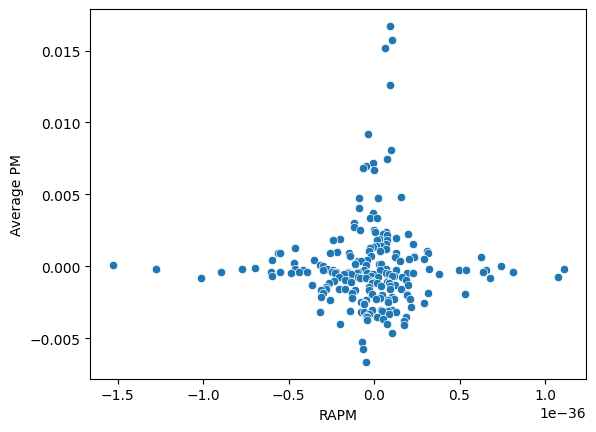

In [13]:
sns.scatterplot(x=results['RAPM'], y=results['Average PM'])